# 1. Chapter : Proximity Analysis (근접 분석)
거리 측정을 통해 지도상에서 근접분석을 진행

## 1-1. 데이터 불러오기

In [1]:
import pandas as pd
import geopandas as gpd
import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap

In [2]:
# US 환경보호국에서 진행한 필라델피아 지역의 독성 화학물질 방출을 추적한 데이터 불러오기
releases = gpd.read_file("../../01_data/toxic_release_pennsylvania/toxic_release_pennsylvania/toxic_release_pennsylvania.shp")

releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


동일한 지역의 대기질 모니터링한 데이터셋 불러오기

In [3]:
stations = gpd.read_file("../../01_data/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.31)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.29 271248.9)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.58 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


## 1-2. 거리 측정하기
두 데이터 프레임 포인트간의 거리를 측정하기 전에, 좌표계를 동일하게 변경해줘야 포인트간의 거리 측정이 가능하므로, EPSG 2272로 변경한다.

In [4]:
print(stations.crs)
print(releases.crs)

EPSG:2272
EPSG:2272


또한 CRS가 어떤 단위(미터, 발 또는 다른 단위)를 사용하는지 확인합니다. 이 경우 EPSG 2272에는 피트 단위가 있습니다.\
GeoPandas에서 거리를 계산하는 것은 비교적 간단합니다.\
아래 코드 셀은 최근 릴리스에서 비교적 최근에 발생한 릴리스 사건과 GeoDataFrame 스테이션의 모든 스테이션 사이의 거리(피트)를 계산합니다.

In [5]:
# 특정 릴리즈 하나를 선택
recent_release = releases.iloc[360]

# 특정 릴리즈로부터 각 측정소까지의 거리를 계산
distances = stations.geometry.distance(recent_release.geometry)
distances

0     44778.509761
1     51006.456589
2     77744.509207
3     14672.170878
4     43753.554393
5      4711.658655
6     23197.430858
7     12072.823097
8     79081.825506
9      3780.623591
10    27577.474903
11    19818.381002
dtype: float64

### 1) 측정지점의 평균 거리 구하기

In [6]:
# 계산된 결과를 가지고 각 측정소의 거리의 평균을 구하기
print(f"모니터링 측정지점의 전체 평균 거리 : {distances.mean():.4f} feet")

모니터링 측정지점의 전체 평균 거리 : 33516.2849 feet


### 2) 가장 가까운 측정지점의 거리 구하기

In [7]:
print(f"가장 가까운 측정지점 : {distances.min():.4f} feet")
print("----------------------")
# 거리의 최소값인 지점의 index 번호를 반환하는 idxmin() 사용
print(stations.iloc[distances.idxmin()][['ADDRESS', 'LATITUDE', 'LONGITUDE']])

가장 가까운 측정지점 : 3780.6236 feet
----------------------
ADDRESS      3100 Penrose Ferry Road
LATITUDE                    39.91279
LONGITUDE                 -75.185448
Name: 9, dtype: object


## 1-3. 버퍼 생성하기
포인트를 중심으로 원형의 버퍼를 생성하기

In [8]:
# 2마일 반경의 버퍼 생성
two_mile_buffer = stations.geometry.buffer(2*5200)
two_mile_buffer.head()

0    POLYGON ((2721784.641 257149.31, 2721734.562 2...
1    POLYGON ((2682334.29 271248.9, 2682284.211 270...
2    POLYGON ((2744726.638 280980.247, 2744676.559 ...
3    POLYGON ((2703478.58 233247.101, 2703428.501 2...
4    POLYGON ((2726799.773 251134.976, 2726749.694 ...
dtype: geometry

`folium.GeoJson()`을 사용하여 맵에 폴리곤으로 표현하기

In [63]:
# 측정지점을 배경맵에 표현하기
m = folium.Map(location=[39.9526, -75.1652], zoom_start=11)

# 히트맵으로 독성화학물질이 퍼져나간 경로를 표현하기
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']]).add_to(m)

# 측정소를 마커로 표현하기
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# 각 폴리곤을 배경맵에 표현하기
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

m

![usa_hospital1](usa_hospital1.png)

## 1-4. 폴리곤 결합
측정소에서 2마일 이내에 독성 방출이 발생했는지 확인하기 위해 각 폴리곤에 대해 테스트를 진행\
먼저 여러 버퍼객체를 하나의 멀티폴리곤으로 변경하는 작업을 수행하기 위해 unary_union을 실시

Type : <class 'shapely.geometry.multipolygon.MultiPolygon'>


C:\Users\gkdis\AppData\Local\Temp\ipykernel_3944\2320020742.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_ply = two_mile_buffer.geometry.unary_union


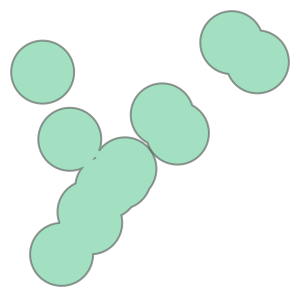

In [11]:
# 여러 폴리곤들을 단일 폴리곤으로 변경
union_ply = two_mile_buffer.geometry.unary_union
print(f"Type : {type(union_ply)}")

union_ply

In [16]:
# 가장 가까운 측정소가 2마일 이내인지 확인
union_ply.contains(releases.iloc[360].geometry)

True

In [17]:
# 다른 스테이션도 2마일 안에 들어오는지 확인
union_ply.contains(releases.iloc[358].geometry)

False

# 2. Exercise
위기 대응 팀의 일원으로, 뉴욕시에서 발생한 충돌 사고에 대해 병원들이 어떻게 대응하고 있는지 파악

In [37]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon
from shapely.geometry import mapping

import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

## 2-1. 데이터 불러오기
2013년 부터 2018년 사이에 발생한 자동차 충돌 사고 데이터 확인 및 시각화 진행

### 1) 충돌 데이터 불러오기

In [19]:
collisions = gpd.read_file("../../01_data/NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions.shp")

collisions.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET,CROSS STRE,OFF STREET,...,CONTRIBU_2,CONTRIBU_3,CONTRIBU_4,UNIQUE KEY,VEHICLE TY,VEHICLE _1,VEHICLE _2,VEHICLE _3,VEHICLE _4,geometry
0,07/30/2019,0:00,BRONX,10464,40.841100,-73.784960,"(40.8411, -73.78496)",None,None,121 PILOT STREET,...,Unspecified,None,None,4180045,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,None,None,POINT (1043750.211 245785.815)
1,07/30/2019,0:10,QUEENS,11423,40.710827,-73.770660,"(40.710827, -73.77066)",JAMAICA AVENUE,188 STREET,None,...,None,None,None,4180007,Sedan,Sedan,None,None,None,POINT (1047831.185 198333.171)
2,07/30/2019,0:25,None,None,40.880318,-73.841286,"(40.880318, -73.841286)",BOSTON ROAD,None,None,...,None,None,None,4179575,Sedan,Station Wagon/Sport Utility Vehicle,None,None,None,POINT (1028139.293 260041.178)
3,07/30/2019,0:35,MANHATTAN,10036,40.756744,-73.984590,"(40.756744, -73.98459)",None,None,155 WEST 44 STREET,...,None,None,None,4179544,Box Truck,Station Wagon/Sport Utility Vehicle,None,None,None,POINT (988519.261 214979.32)
4,07/30/2019,10:00,BROOKLYN,11223,40.600090,-73.965910,"(40.60009, -73.96591)",AVENUE T,OCEAN PARKWAY,None,...,None,None,None,4180660,Station Wagon/Sport Utility Vehicle,Bike,None,None,None,POINT (993716.669 157907.212)


In [65]:
# 위도, 경도 컬럼을 이용해서 지도에 시각화 표현 진행
m_1 = folium.Map(location=[40.7, -74], zoom_start=11)

# 충돌 데이터 시각화
HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m_1)

m_1

![usa_hospital2](usa_hospital2.png)

### 2) 병원 데이터 불러오기

In [25]:
# 병원 데이터 불러오기
hospitals = gpd.read_file("../../01_data/nyu_2451_34494/nyu_2451_34494/nyu_2451_34494.shp")
hospitals.head()

,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,latitude,longitude,geometry
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415,Beds,36005,1008872.0,246596.0,40.843490,-73.911010,POINT (1008872 246596)
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164,Beds,36005,1011044.0,242204.0,40.831429,-73.903178,POINT (1011044 242204)
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225,Beds,36005,1027505.0,248287.0,40.848060,-73.843656,POINT (1027505 248287)
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457,Beds,36005,1027042.0,251065.0,40.855687,-73.845311,POINT (1027042 251065)
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362,Beds,36005,1005154.0,236853.0,40.816758,-73.924478,POINT (1005154 236853)


In [66]:
# 병원 데이터 지도 시각화
m_2 = folium.Map(location=[40.7, -74], zoom_start=11)

# 마커로 병원 위치 시각화
for idx, row in hospitals.iterrows():
    Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(m_2)
    
m_2

![usa_hospital3](usa_hospital3.png)

In [27]:
# 좌표계 확인
print(hospitals.crs)
print(collisions.crs)

EPSG:2263
EPSG:2263


## 2-2. 충돌사고 데이터 분석

### 1) 사고 지점에서 가장 가까운 병원이 10km가 넘는 지점 탐색
`collisions`의 모든 데이터 중에서 충돌이 일어난 지점에서 가장 가까운 병원이 10km가 넘는 지점을 탐색

In [49]:
# 병원 포인트 데이터에서 10km 버퍼를 생성
coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(10000)

# 버퍼로 생성된 폴리곤 객체를 union
my_union = coverage.geometry.union_all()

# 10km 범위 밖에서 발생한 사고 데이터만 추출하기
outside_range = collisions.loc[~collisions['geometry'].apply(lambda x: my_union.contains(x))]

print(f"전체 충돌사고 : {len(collisions)}건")
print(f"10km 밖에서 발생한 충돌사고 : {len(outside_range)}건")

# 비율로 확인
percentage = round(100*len(outside_range)/len(collisions), 2)
print(f"10km 밖에서 발생한 충돌사고 비율 : {percentage:.4f}%")

전체 충돌사고 : 261905건
10km 밖에서 발생한 충돌사고 : 39595건
10km 밖에서 발생한 충돌사고 비율 : 15.1200%


### 2) 가장 빠른 병원으로 이송하는 시스템 만들기

In [51]:
# 가장 가까운 병원 찾는 함수 만들기
def best_hospital(collision_location):
    idx_min = hospitals.geometry.distance(collision_location).idxmin()
    my_hospital = hospitals.iloc[idx_min]
    name = my_hospital['name']
    return name

print(best_hospital(outside_range.geometry.iloc[0]))

CALVARY HOSPITAL INC


### 3) 가장 수요가 높은 병원 찾기
가장 많은 환자가 방문한 병원 찾기

In [59]:
outside_range.geometry.apply(best_hospital).value_counts().idxmax()

'JAMAICA HOSPITAL MEDICAL CENTER'

## 2-3. 결론 : 신설 병원 위치 선정하기

In [67]:
# 기본 배경맵 제작
m_3 = folium.Map(location=[40.7, -74], zoom_start=11)

# 병원 버퍼 생성
coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(10000)

# 시각화 표현
folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m_3)

# 히트맵 표현
HeatMap(data=outside_range[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m_3)
folium.LatLngPopup().add_to(m_3)

m_3

![usa_hospital4](usa_hospital4.png)

#### 신설 병원 우선 지역 2개소 선택
> 첫 번째 위치 :
- lat : 40.6714
- long : -73.8492
> 두 번째 위치 :
- lat : 40.6702
- long : -73.7612 

In [68]:
# 첫 번째 위치
lat_1 = 40.6714
long_1 = -73.8492

# 두 번째 위치
lat_2 = 40.6702
long_2 = -73.7612


# 새로운 병원의 위치를 데이터프레임으로 저장
new_df = pd.DataFrame(
    {'Latitude': [lat_1, lat_2],
        'Longitude': [long_1, long_2]})
new_gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.Longitude, new_df.Latitude))
new_gdf.crs = {'init' :'epsg:4326'}
new_gdf = new_gdf.to_crs(epsg=2263)

# 비율 확인
new_coverage = gpd.GeoDataFrame(geometry=new_gdf.geometry).buffer(10000)
new_my_union = new_coverage.geometry.unary_union
new_outside_range = outside_range.loc[~outside_range["geometry"].apply(lambda x: new_my_union.contains(x))]
new_percentage = round(100*len(new_outside_range)/len(collisions), 2)
print("(NEW) Percentage of collisions more than 10 km away from the closest hospital: {}%".format(new_percentage))

# make the map
m_4 = folium.Map(location=[40.7, -74], zoom_start=11) 
folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m_4)
folium.GeoJson(new_coverage.geometry.to_crs(epsg=4326)).add_to(m_4)

for idx, row in new_gdf.iterrows():
    Marker([row['Latitude'], row['Longitude']]).add_to(m_4)
HeatMap(data=new_outside_range[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m_4)
folium.LatLngPopup().add_to(m_4)

m_4

![usa_hospital4](usa_hospital5.png)